## О проекте "Анализ активности пользователей мобильного приложения"

Цель: разобраться, как ведут себя пользователи мобильного приложения после внедрение нового шрифта.

Задачи:
Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
Исследовать результаты A/A/B-эксперимента.

## Обзор и подготовка данных
Путь к файлу: /datasets/logs_exp.csv. 

**Описание данных:**

Каждая запись в логе — это действие пользователя, или событие.

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


In [1]:
import pandas as pd
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns
import numpy as np
import math as mth

In [2]:
df=pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

df['EventTimestamp']=pd.to_datetime(df['EventTimestamp'], unit='s') # приведение к datetime
df.columns = [x.lower() for x in df.columns] # нижний регистр колонок
df.info()
df.shape[0]
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       244126 non-null  object        
 1   deviceidhash    244126 non-null  int64         
 2   eventtimestamp  244126 non-null  datetime64[ns]
 3   expid           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246


In [3]:
print(df.duplicated().sum()) #проверка на полные дубликаты
df=df.drop_duplicates()

413


**Обнаружено и удалено 413 полных дубликатов**

In [4]:
display(df.isna().sum()) # проверка на пропуски

#df['date']=pd.to_datetime(df['eventtimestamp'], format='%Y-%m-%dT')
df['date']=df.eventtimestamp.apply (lambda x: x. date ()) # извлекаем дату в отдельный столбец
df.head()

eventname         0
deviceidhash      0
eventtimestamp    0
expid             0
dtype: int64

,eventname,deviceidhash,eventtimestamp,expid,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Данные содержат большую таблицу на 244126 строк с четырьмя колонками. Время события необходимо перевести из целочисленного типа данных в datetime. Для удобства было решено перевести названия всех колонок к нижнему регистру. Добавлен отдельный столбец с датой. Пропусков в данных не было выявлено.

## Изучение и проверка данных

Всего событий: 243713
Всего пользователей: 7551
Среднее значение событий на пользователя: 32.27559263673685
Медианное значение событий на пользователя: 20.0
Минимальное значение событий на пользователя: 1
Максимальное значение событий на пользователя: 2307
Начало периода: 2019-07-25
Конец периода: 2019-08-07


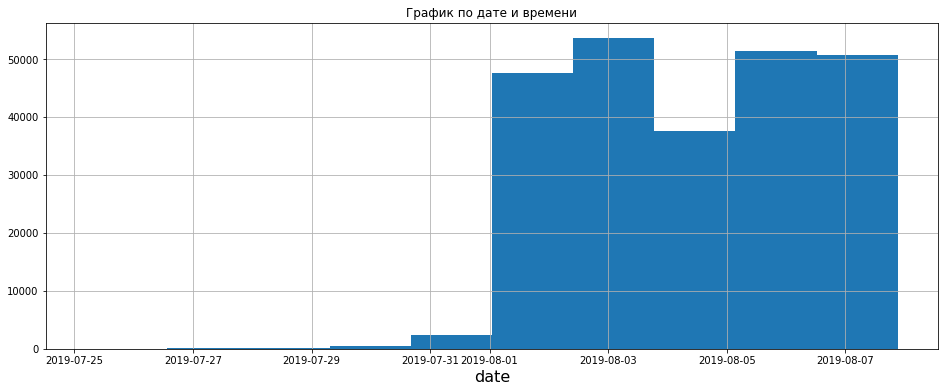

In [5]:
evs=len(df['eventname'])
users=len(df['deviceidhash'].unique())
eu=df.groupby('deviceidhash').agg({'eventname':'count'}).reset_index()

print('Всего событий:', evs)
print('Всего пользователей:', users)
print('Среднее значение событий на пользователя:', evs/users)
print('Медианное значение событий на пользователя:', eu['eventname'].median())
print('Минимальное значение событий на пользователя:', eu['eventname'].min())
print('Максимальное значение событий на пользователя:', eu['eventname'].max())

print('Начало периода:',df['date'].min())
print('Конец периода:',df['date'].max())

df.hist('eventtimestamp',figsize=(16,6))
plt.title(r'График по дате и времени')
plt.xlabel(r'date', fontsize=16)
plt.show()# гистограмма по дате и времени

Аномальных пользователей: 76
99% пользователей совершают менее 200.5 событий
Количество строк:
до обработки 243713 строк
после обработки 209333 строк


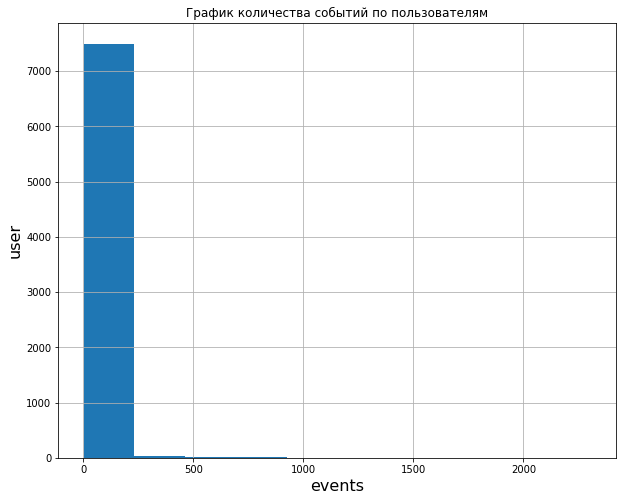

In [6]:
eu['eventname'].hist(figsize=(10,8))
plt.ylabel(r'user', fontsize=16)
plt.xlabel(r'events', fontsize=16)
plt.title(r'График количества событий по пользователям')
print('Аномальных пользователей:', eu.query('eventname > 200')['deviceidhash'].count())

print('99% пользователей совершают менее', eu['eventname'].quantile(0.99), 'событий') # Вычисляю значение 99 квантиля

# Получаю список идентификаторов устройств c аномальным количеством событий
junk = list(eu.query('eventname > 200')['deviceidhash'])
print('Количество строк:')
print('до обработки',len(df), 'строк')
# Удаляю все записи с идентификаторами из списка 'junk'
df2 = df.query('deviceidhash not in @junk').copy()
print('после обработки',len(df2), 'строк')

По гистограмме стало заметно, что мы имеем разные по полноте данные, до августа крайне мало информации в датафрейме. На самом деле мы располагаем данными за первую неделю августа 2019 года. 99% пользователей совершают менее 200.5 событий, соответственно аномалии (76) были удалены.

In [7]:
#оставляем данные только за первую неделю августа
df2['month']=df2['eventtimestamp'].dt.month
df2=df2.query('month==8')

df2.info()
print('Потерянных пользователей в абсолютном исчислении:', users-len(df2['deviceidhash'].unique()))
print('Потерянных пользователей в относительном исчислении:', '{:.1%}'.format((users-len(df2['deviceidhash'].unique()))/users))
print()
print('Потерянных событий в абсолютном исчислении:', evs-len(df2['eventname']))
print('Потерянных событий в относительном исчислении:', '{:.1%}'.format((evs-len(df2['eventname']))/evs))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206615 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       206615 non-null  object        
 1   deviceidhash    206615 non-null  int64         
 2   eventtimestamp  206615 non-null  datetime64[ns]
 3   expid           206615 non-null  int64         
 4   date            206615 non-null  object        
 5   month           206615 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.0+ MB
Потерянных пользователей в абсолютном исчислении: 93
Потерянных пользователей в относительном исчислении: 1.2%

Потерянных событий в абсолютном исчислении: 37098
Потерянных событий в относительном исчислении: 15.2%


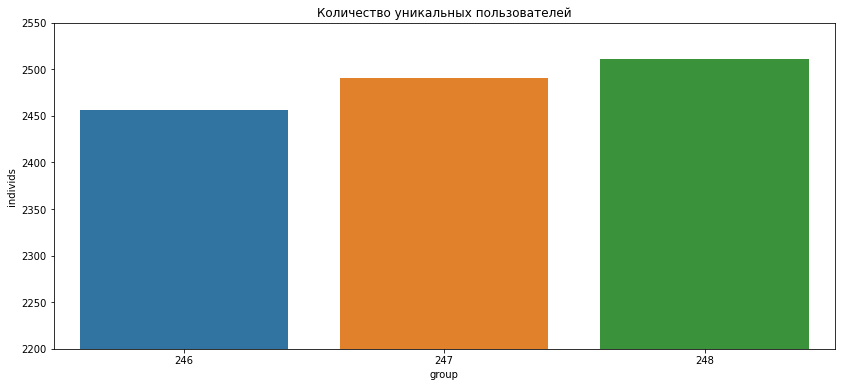

In [8]:
#проверяем,что у нас есть пользователи из всех трёх экспериментальных групп

users_c = df2.groupby('expid').agg({'deviceidhash':'nunique'}).reset_index() 
users_c.columns = ['group', 'individs']

# Рисую график количества уникальных пользователей в каждой группе
plt.figure(figsize=(14, 6)) # Размер графика
plt.title('Количество уникальных пользователей') # Название графика
sns.barplot(y='individs', x='group', data=users_c).set_ylim(2200, 2550)
plt.show()

In [9]:
#проверка на пользователей с несколькими группами теста
users_3 = df2.groupby('deviceidhash').agg({'expid':'nunique'}).reset_index() 
users_3.columns = ['user', 'groups']
users_3[users_3['groups']>1]

,user,groups


**Отбросив старые данные, потеряли 15.2% событий и 93 пользователя. Остались пользователи из всех трёх экспериментальных групп. В ходе проверки не было обнаружено пользователей участвующих в нескольких группах теста.**


## Изучение воронки событий

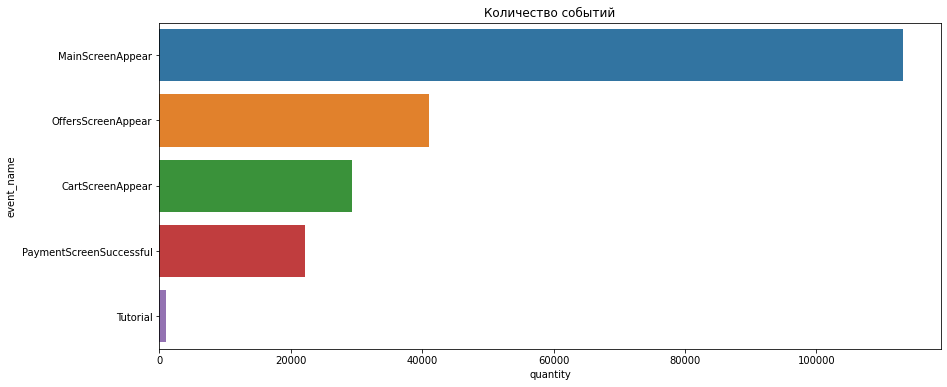

,event_name,quantity
1,MainScreenAppear,113264
2,OffersScreenAppear,40956
0,CartScreenAppear,29250
3,PaymentScreenSuccessful,22164
4,Tutorial,981


In [10]:
#частота событий в логе
event_cnt = df2.groupby('eventname').agg({'date':'count'}).reset_index().sort_values(by='date', ascending=False)
event_cnt.columns = ['event_name', 'quantity']

# график количества записей для каждого события
plt.figure(figsize=(14, 6)) # Размер графика
plt.title('Количество событий') # Название графика
sns.barplot(x='quantity', y='event_name', data=event_cnt)
plt.show()
display(event_cnt)

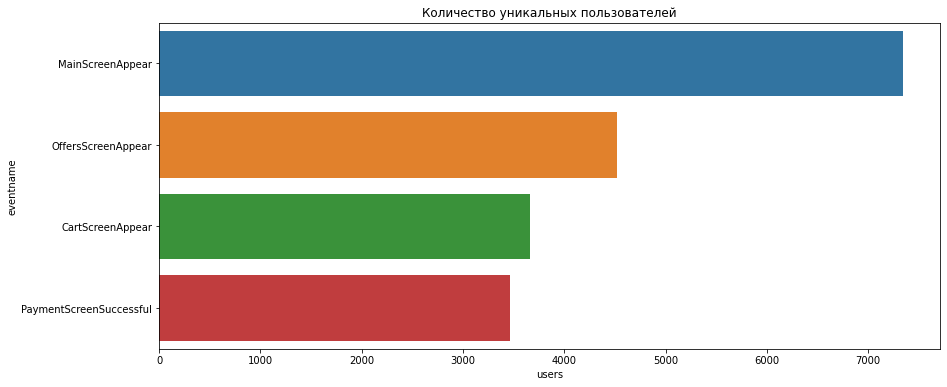

,eventname,users
1,MainScreenAppear,7344
2,OffersScreenAppear,4517
0,CartScreenAppear,3658
3,PaymentScreenSuccessful,3463
4,Tutorial,824


In [11]:
#количество пользователей, совершавших каждое из событий
ev_list=df2.groupby('eventname').agg({'deviceidhash':'nunique'}).reset_index().sort_values(by='deviceidhash', ascending=False)
#ev_list
ev_list.columns = ['eventname','users']


#график количества уникальных пользователей для каждого события
plt.figure(figsize=(14, 6)) # Размер графика
plt.title('Количество уникальных пользователей') # Название графика
sns.barplot(x='users', y='eventname', data=ev_list[:-1])
plt.show()
display(ev_list.sort_values(by='users',ascending=False))

In [12]:
#Доля пользователей, хоть раз совершашвших события
users_sum=len(df2['deviceidhash'].unique()) #всего уникальных пользователей
ev_list['share']=100*ev_list['users']/users_sum
ev_list.sort_values(by='share',ascending=False)

,eventname,users,share
1,MainScreenAppear,7344,98.471440
2,OffersScreenAppear,4517,60.565835
0,CartScreenAppear,3658,49.048002
3,PaymentScreenSuccessful,3463,46.433360
4,Tutorial,824,11.048538


Наиболее часто вызываемое событие в приложении - MainScreenAppear - основной экран, данное событие было вызвано 117328 раз. Главный экран приложения был вызван в 98,5% случаев, то есть существует часть пользователей, у которых либо не запустилось приложение, либо оно зависает.

Наименее часто вызываемое событие в приложении - Tutorial - руководство приложения - данное событие было вызвано всего 1005 раз. Доля хотя бы раз столкнувшихся с руководством пользователей является отстающей в рейтинге - 11%. Это связано с тем, что пользователи пропускают туториалы, не любят тратить время на обучение.

Главное событие для приложения - PaymentScreenSuccessful - экран успешной оплаты, было вызвано 33918 раз и имеет показатель доли пользователей почти 47%, что чуть меньше события CartScreenAppear - просмотра корзины, где доля в районе 50%. То есть небольшой процент пользователей добавляют товары в корзину, но не оплачивают их впоследствие.

OffersScreenAppear - экран с продуктами - вызывался 46333 и имеет долю пользователей почти в 61%. Получается, что практически половина пользователей не то, что до покупки не доходят, они даже не рассматривают продукцию на странице приложения.

Скорее всего порядок событий следующий:

1) MainScreenAppear

2) Tutorial

3) OffersScreenAppear

4) CartScreenAppear

5) PaymentScreenSuccessful	

Однако важно понимать, что данная цепочка далеко не всегда работает именно в таком порядке, так как человек может открывать хаотичные вкладки, не обращать внимание на туториал, всплывающие окна и тд.

In [13]:
group_evs_cnt = df2.query('eventname != "Tutorial"').groupby('eventname').agg({'deviceidhash':'nunique'}).reset_index().sort_values('deviceidhash', ascending=False)
#соберем таблицу воронки событий

    # рассчитаем процент для каждого шага
group_evs_cnt['pct'] = (100 - 100 * abs(group_evs_cnt['deviceidhash'].pct_change()).fillna(0)).astype(int)
    # применим функцию shift 
group_evs_cnt['value-1'] = group_evs_cnt['deviceidhash'].shift(1)
    # рассчитаем процент между каждым шагом и первым шагом в таблице
group_evs_cnt['pct_from_first'] = (group_evs_cnt['deviceidhash'] / group_evs_cnt['deviceidhash'].loc[1] * 100).fillna(0).astype(int)

group_evs_cnt

,eventname,deviceidhash,pct,value-1,pct_from_first
1,MainScreenAppear,7344,100,NaN,100
2,OffersScreenAppear,4517,61,7344.0,61
0,CartScreenAppear,3658,80,4517.0,49
3,PaymentScreenSuccessful,3463,94,3658.0,47


От первого события до оплаты доходят 47% пользователей. Больше всего пользователей теряются на шаге OffersScreenAppear, то есть 39% пользователей не доходят до просмотра продукции в приложении, явно что-то мешает им перейти в каталог или карточки предложений просто не всегда показываются.

## Изучение результататов эксперимента

In [14]:
#подсчет уникальных пользователей в каждой группе эксперимента
users_cnt = df2.groupby('expid').agg({'deviceidhash':'nunique'}).reset_index()
users_cnt.columns = ['group', 'users']
users_cnt

,group,users
0,246,2456
1,247,2491
2,248,2511


Гипотезы в общем виде

**Н0: Доли двух групп не отличаются друг от друга**

**Н1: Доли двух групп отличаются друг от друга**

В качестве статистического критерия используем z-тест для пропорций.

In [15]:
# Создаю сводную таблицу с количеством пользователей в каждом событии для каждой группы
user_pvt = (
    df2
    .groupby(['expid', 'eventname']).agg({'deviceidhash':'nunique'})
    .pivot_table(index='eventname', columns='expid', values='deviceidhash')
    .reset_index()
    .sort_values(246, ascending=False)
)

In [16]:
user_pvt.columns=['eventname','246','247','248']
user_pvt['both']=user_pvt['246']+user_pvt['247'] #столбец с объединенной группой
both_u=users_cnt['users'][0]+users_cnt['users'][1]
print(user_pvt)

                 eventname   246   247   248  both
1         MainScreenAppear  2423  2454  2467  4877
2       OffersScreenAppear  1514  1498  1505  3012
0         CartScreenAppear  1238  1216  1204  2454
3  PaymentScreenSuccessful  1172  1136  1155  2308
4                 Tutorial   269   279   276   548


In [17]:
# Создаю списки с количеством пользователей для каждого события в каждой группе
# 246 экспериментальная группа:
A1_list = user_pvt['246'].tolist()
# 247 экспериментальная группа:
A2_list = user_pvt['247'].tolist()
# 248 экспериментальная группа:
B_list = user_pvt['248'].tolist()
#объединенная группа 246 и 247
both_list = user_pvt['both'].tolist()

In [18]:
# Функция для расчёта статистически значимой разницы между долями двух генеральных совокупностей
def stat_value(first_list, second_list, size1, size2, alpha):
    
    # Список с названием события в приложении    
    event_name_list = []
    for event in user_pvt['eventname'].unique()[:-1]:
        event_name_list.append(event)
    # Основной цикл функции, который вычисляет p-value и проверяет нулевую гипотезу для каждого события 
    for x in range(0, len(first_list)-1):
        x1 = first_list[x] 
        x2 = second_list[x]
    
        successes = np.array([x1, x2])
        trials = np.array([size1, size2])
        p1 = successes[0]/trials[0] # Расчёт значения пропорции в первой группе
        p2 = successes[1]/trials[1] # Расчёт значения пропорции во второй группе
        # Расчёт совокупной пропорции в комбинированном датасете
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2  # Расчёт азницы пропорций между группами
        # Расчёт статистики в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        distr = st.norm(0, 1) # Указание стандартного отклонения в нормальном распределении
        p_value = 1 - distr.cdf(z_value) # Расчёт значения статистической разницы между группами
        # Вывод полученных результатов на экран
        print('Событие:', event_name_list[x])
        print('p-value: ', p_value)
        # Сравнение полученного p-value с установленным уровнем статистической значимости 
        if (p_value < alpha):
            print("Результат:",  "Нулевая гипотеза отвергнута: между долями есть значимая разница")
        else:
            print("Результат:",  "Нулевая гипотеза не отвергнута: нет оснований считать доли разными")
        print('   ')

In [19]:
print('Относительная разница в количестве пользователей между группами 246 и 247:',abs(1 - users_cnt['users'][0]/users_cnt['users'][1]),
      '\n 247 и 248:', abs(1-users_cnt['users'][1]/users_cnt['users'][2]),
      '\n 246 и 248:',abs(1-users_cnt['users'][0]/users_cnt['users'][2]))

Относительная разница в количестве пользователей между группами 246 и 247: 0.014050582095543995 
 247 и 248: 0.00796495420151333 
 246 и 248: 0.021903624054161686


Формирование контрольных групп корректно, можно проводить А/А тесты.

In [20]:
# Вызываю функцию 'stat_value' для групп 246 и 247
stat_value(A1_list, A2_list, users_cnt['users'][0], users_cnt['users'][1], 0.05/16)

Событие: MainScreenAppear
p-value:  0.33654759036042425
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: OffersScreenAppear
p-value:  0.13851385850384912
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: CartScreenAppear
p-value:  0.13149813318583892
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: PaymentScreenSuccessful
p-value:  0.06793129183636992
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   


Таким образом, статистически значимой разницы между долями двух групп нет. Это характерно для всех событий в обоих группах.
Получается, что разбиение на группы организовано правильно.

In [21]:
# Вызываю функцию 'stat_value' для групп 246 и 248
stat_value(A1_list, B_list,users_cnt['users'][0], users_cnt['users'][2],0.05/16)

Событие: MainScreenAppear
p-value:  0.12190005370239487
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: OffersScreenAppear
p-value:  0.10875933703997143
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: CartScreenAppear
p-value:  0.041587040584142865
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: PaymentScreenSuccessful
p-value:  0.11196611703410875
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   


Между количеством пользователей совершивших каждое событие в группе 246 и 248 нет статистически значимой разницы, можно считать, что доля пользователей, совершивших одно и тоже событие, одинаковая для обеих групп.

In [22]:
# Вызываю функцию 'stat_value' для групп 247 и 248
stat_value(A2_list, B_list,users_cnt['users'][1], users_cnt['users'][2],0.05/16)

Событие: MainScreenAppear
p-value:  0.22726681153781514
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: OffersScreenAppear
p-value:  0.44253731347479097
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: CartScreenAppear
p-value:  0.269839796498512
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: PaymentScreenSuccessful
p-value:  0.6099698378930762
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   


Между количеством пользователей совершивших каждое событие в группе 247 и 248 нет статистически значимой разницы, можно считать, что доля пользователей, совершивших одно и тоже событие, одинаковая для обеих групп.

In [23]:
# Вызываю функцию 'stat_value' для объединенной группы и 248
stat_value(both_list, B_list,both_u, users_cnt['users'][2],0.05/16)

Событие: MainScreenAppear
p-value:  0.13093201429777923
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: OffersScreenAppear
p-value:  0.21400917356070637
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: CartScreenAppear
p-value:  0.08809576910463768
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   
Событие: PaymentScreenSuccessful
p-value:  0.2954355451086992
Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными
   


Между количеством пользователей совершивших каждое событие в объединенной группе и тестовой 248 нет статистически значимой разницы, можно считать, что доля пользователей, совершивших одно и тоже событие, одинаковая для обеих групп.

In [24]:
print('Вероятность ошибки при alpha=0.05 и 4 проверках:', '{:.1%}'.format(1-(1-0.05)**3))
print()
print('Скорректированный alpha для 4 проверок:', '{:.2%}'.format(0.05/16))
print()
print('Вероятность ошибки при скорретированном alpha и 4 проверках:', '{:.1%}'.format(1-(1-0.05/16)**3))

Вероятность ошибки при alpha=0.05 и 4 проверках: 14.3%

Скорректированный alpha для 4 проверок: 0.31%

Вероятность ошибки при скорретированном alpha и 4 проверках: 0.9%


**Был выбран уровень значимости 5% и скорректирован до 0,31%, так как вероятность ошибки при 5% более 14%. В результате ни одна нулевая гипотеза не будет отклонена, но скорректированный уровень значимости внушает больше доверия к результатам тестов при сниженной вероятности ошибки до 0.9%. Мы протестировали по 4 гипотезы в пределах 4 тестов (1 А/А тест и 3 А/В теста), итого было сделано 16 проверок.**

## Общий вывод

В ходе проведения А/Б теста, выяснилось, что между количеством пользователей, совершивших каждое событие в группе 247 и 248 нет статистически значимой разницы, то есть можно считать, что доля пользователей совершивших одно и тоже событие одинаковая для обеих групп. Таким образом, что новые шрифты, показанные группе Б, никак не повлияли на поведение пользователей внутри приложения.

От первого события до оплаты доходят 47% пользователей. Больше всего пользователей теряются на шаге **OffersScreenAppear**, то есть 39% пользователей не доходят до просмотра продукции в приложении.

**MainScreenAppear** - самое популярное событие, оно было вызвано 117328 раз. Однако существует часть пользователей, у которых либо не запустилось приложение, либо оно зависает.

Наименее часто вызываемое событие в приложении - **Tutorial** - руководство приложения - данное событие было вызвано всего 1005 раз. Доля хотя бы раз столкнувшихся с руководством пользователей является отстающей в рейтинге - 11%. 